In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import csv
import typing
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy
import copy
from networkx.drawing.nx_agraph import graphviz_layout
%matplotlib inline

## Load data, create graph and print general statistics

In [3]:
file = '../data/casts.csv'

In [4]:
data = pd.read_csv(file, sep=';', header=None).values.tolist()

In [5]:
print("Number of records:", len(data))

Number of records: 46233


In [6]:
def create_graph(data):
    """Create graph from load records from csv."""
    g = nx.Graph()
    actors_in_film = {}
    
    for i in data:
        g.add_node(i[2])
        if i[1] not in actors_in_film:
            actors_in_film[i[1]] = [] 
        actors_in_film[i[1]].append(i[2])

    for film in actors_in_film:
        for actor in actors_in_film[film]:
            for other_actor in actors_in_film[film]:
                if actor != other_actor:
                    g.add_edge(actor, other_actor)
    return g

In [7]:
g = create_graph(data)

In [8]:
density = len(g.edges()) / (len(g.nodes()) * (len(g.nodes()) - 1) / 2)

print("Number of nodes:", len(g.nodes()) )
print("Number of edges:", len(g.edges()) )
print("Density:", density)
print("Number of components:", nx.number_connected_components(g))

Number of nodes: 16615
Number of edges: 155661
Density: 0.0011278082315198785
Number of components: 637


## TOP key players

In [9]:
def compute_centrality(centrality, g, name, k=10):
    c = centrality(g)
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    for actor, value in c[:10]:
        print("{}  -  {}".format(actor, value))
    # adding attribute to graph
    for actor, value in c:
        g.node[actor][name] = float(value)

### Degree centrality

In [10]:
compute_centrality(nx.degree_centrality, g, 'degree_centrality')

s a  -  0.19922956542674852
Humphrey Bogart  -  0.025941976646201997
James Stewart  -  0.022511135187191524
Gary Cooper  -  0.022270374383050438
John Gielgud  -  0.022270374383050438
John Carradine  -  0.022089803779944624
Peter Lorre  -  0.021668472372697724
C.Aubrey Smith  -  0.02028409774888648
Henry Fonda  -  0.01950162513542795
Burt Lancaster  -  0.018779342723004695


### Eigenvector centrality

In [11]:
compute_centrality(nx.eigenvector_centrality_numpy, g, 'eigenvector_centrality')

s a  -  0.3256610437525204
C.Aubrey Smith  -  0.0870886494808833
John Carradine  -  0.08560693224684064
James Stewart  -  0.08366471404577969
John Gielgud  -  0.08139754459630967
Peter Lorre  -  0.07888547799544361
Gary Cooper  -  0.07783435819460513
Basil Rathbone  -  0.07530849903768734
Humphrey Bogart  -  0.07458397505873157
Henry Fonda  -  0.07436720507892242


### Katz centrality

In [12]:
compute_centrality(nx.katz_centrality_numpy, g, 'katz_centrality')

Mimi Miyaki  -  0.3015113445777637
Paula Price  -  0.3015113445777637
Sharise  -  0.3015113445777637
Bianca Trump  -  0.3015113445777637
Stacey Nichols  -  0.30151134457776363
Eric Price  -  0.30151134457776363
Jake Steed  -  0.30151134457776363
Nick E.  -  0.30151134457776363
T.T. Boy  -  0.30151134457776363
Sean Michaels  -  0.3015113445777636


It can be seen that the individual methods differ and give different results and can be tailored to the particular problem being addressed. I use numpy implementations because it can use the full computational potential of a multicore processor. In addition to the above methods, I tried betweenness centrality and closeness centrality but without success. The implementation is on one thread only, and the implementation algorithms are time-consuming and the run time was too long on the graph like this and I didn't let the methods run.

## TOP communities

In [13]:
communities = {}
for c_id, community in enumerate(nx.algorithms.community.k_clique_communities(g, 4)):
    for node in community:
        communities[node] = c_id

# add all actor from one community to groups
community_to_actors = {}
# from the actor as key and community as id value to lists with actors participate in one community
for actor in communities:
    if communities[actor] not in community_to_actors:
        community_to_actors[communities[actor]] = []
    community_to_actors[communities[actor]].append(actor)

# sort by count of the actors
sort_community_to_actors = sorted(community_to_actors.items(), key=lambda x: len(x[1]), reverse=True)

for community in sort_community_to_actors[:10]:
    print("Community id: {}, number of actors: {}\n\tactors: {}".format(community[0], 
                                        len(community[1]), 
                                        ", ".join(community[1]) if len(community[1]) < 15 
                                                                else (", ".join(community[1][:15])+ " and many more...")))
    print()
    print()

# adding attribute to graph
for actor, c_id in communities.items():
    g.node[actor]['c_id'] = c_id

Community id: 0, number of actors: 6118
	actors: Richard Clarke, Jonathan Frakes, Nancy Coleman, Steve Tisch, David Huddlestone, Pamela Sue Martin, William Rushton, Keefe Braselle, Otto Preminger, Corki Corman, Donahue McBride, Ricard Crenna, Rudolph Schildkraut, Martha Hyer, Felicia Farr and many more...


Community id: 582, number of actors: 25
	actors: Ed Herlihy, Mia Farrow, Will Holt, Deborah Rush, Erma Campbell, George Hamlin, Bernice Dowis, Stanley Swerdlow, Ken Chapin, Ellen Garrison, Bruno Bettelheim, Sol Lomita, Stephanie Farrow, Paul Nevens, Irving Howe and many more...


Community id: 133, number of actors: 18
	actors: Mark Wenzel, Joyce Little, Laurie Prance, Dee Croxton, Ian Anderson, Lauren Unger, Ron Hayes, John Rayner, Robert Lee Campbell, John C. Becker, Terry Hines, Poway Emarald Brigade Marching Band, Devon Ericson, Maryedith Burrell, Lissa Laying and many more...


Community id: 112, number of actors: 17
	actors: Marcie Leeds, Al Mathews, Capl Topa, Tip Tipping, Wi

## KevBacon

In [14]:
start_actor=list(g.nodes())[random.randint(0,len(g.nodes))]
print("Start random generated node: {}".format(start_actor))

lengths = nx.single_source_shortest_path_length(g, start_actor)
sum = 0
for actor, length in lengths.items():
    g.node[actor]['Length'] = length
    sum += length

lengths_s = sorted(lengths.items(), key=lambda element: element[1], reverse=True)
print("Average: {}".format(sum/len(lengths)))
print()
print("SMALL 10")
for actor, kevBacon in lengths_s[-10:][::-1]:
    print("{}  -  {}".format(actor, kevBacon))
print()
print("TOP 10")
for actor, kevBacon in lengths_s[:10]:
    print("{}  -  {}".format(actor, kevBacon))
    
# adding attribute to graph
for actor, kevBacon in lengths_s:
    g.node[actor]['kevBacon'] = kevBacon

Start random generated node: Frank Gifford
Average: 3.6181118045412295

SMALL 10
Frank Gifford  -  0
Lauren Hutton  -  1
Red Buttons  -  1
Evel Knievel  -  1
Warren Clarke  -  2
Ed Lauter  -  2
Joe Regalbuto  -  2
Bob Hoskins  -  2
Jane Seymour  -  2
Tom Selleck  -  2

TOP 10
Paredes  -  7
Antonia SanJuan  -  7
Elisa Touati  -  7
Marbel Verdu  -  7
Maria deMederios  -  7
Joe Bordeaux  -  6
Jordi Molla  -  6
Penelope Cruz  -  6
Javier Bardem  -  6
Aldo Puglisi  -  6


## Vizualizations

In [15]:
# export
nx.write_gexf(g, '../results/export_g.gexf')

### Vizualize some 2k nodes

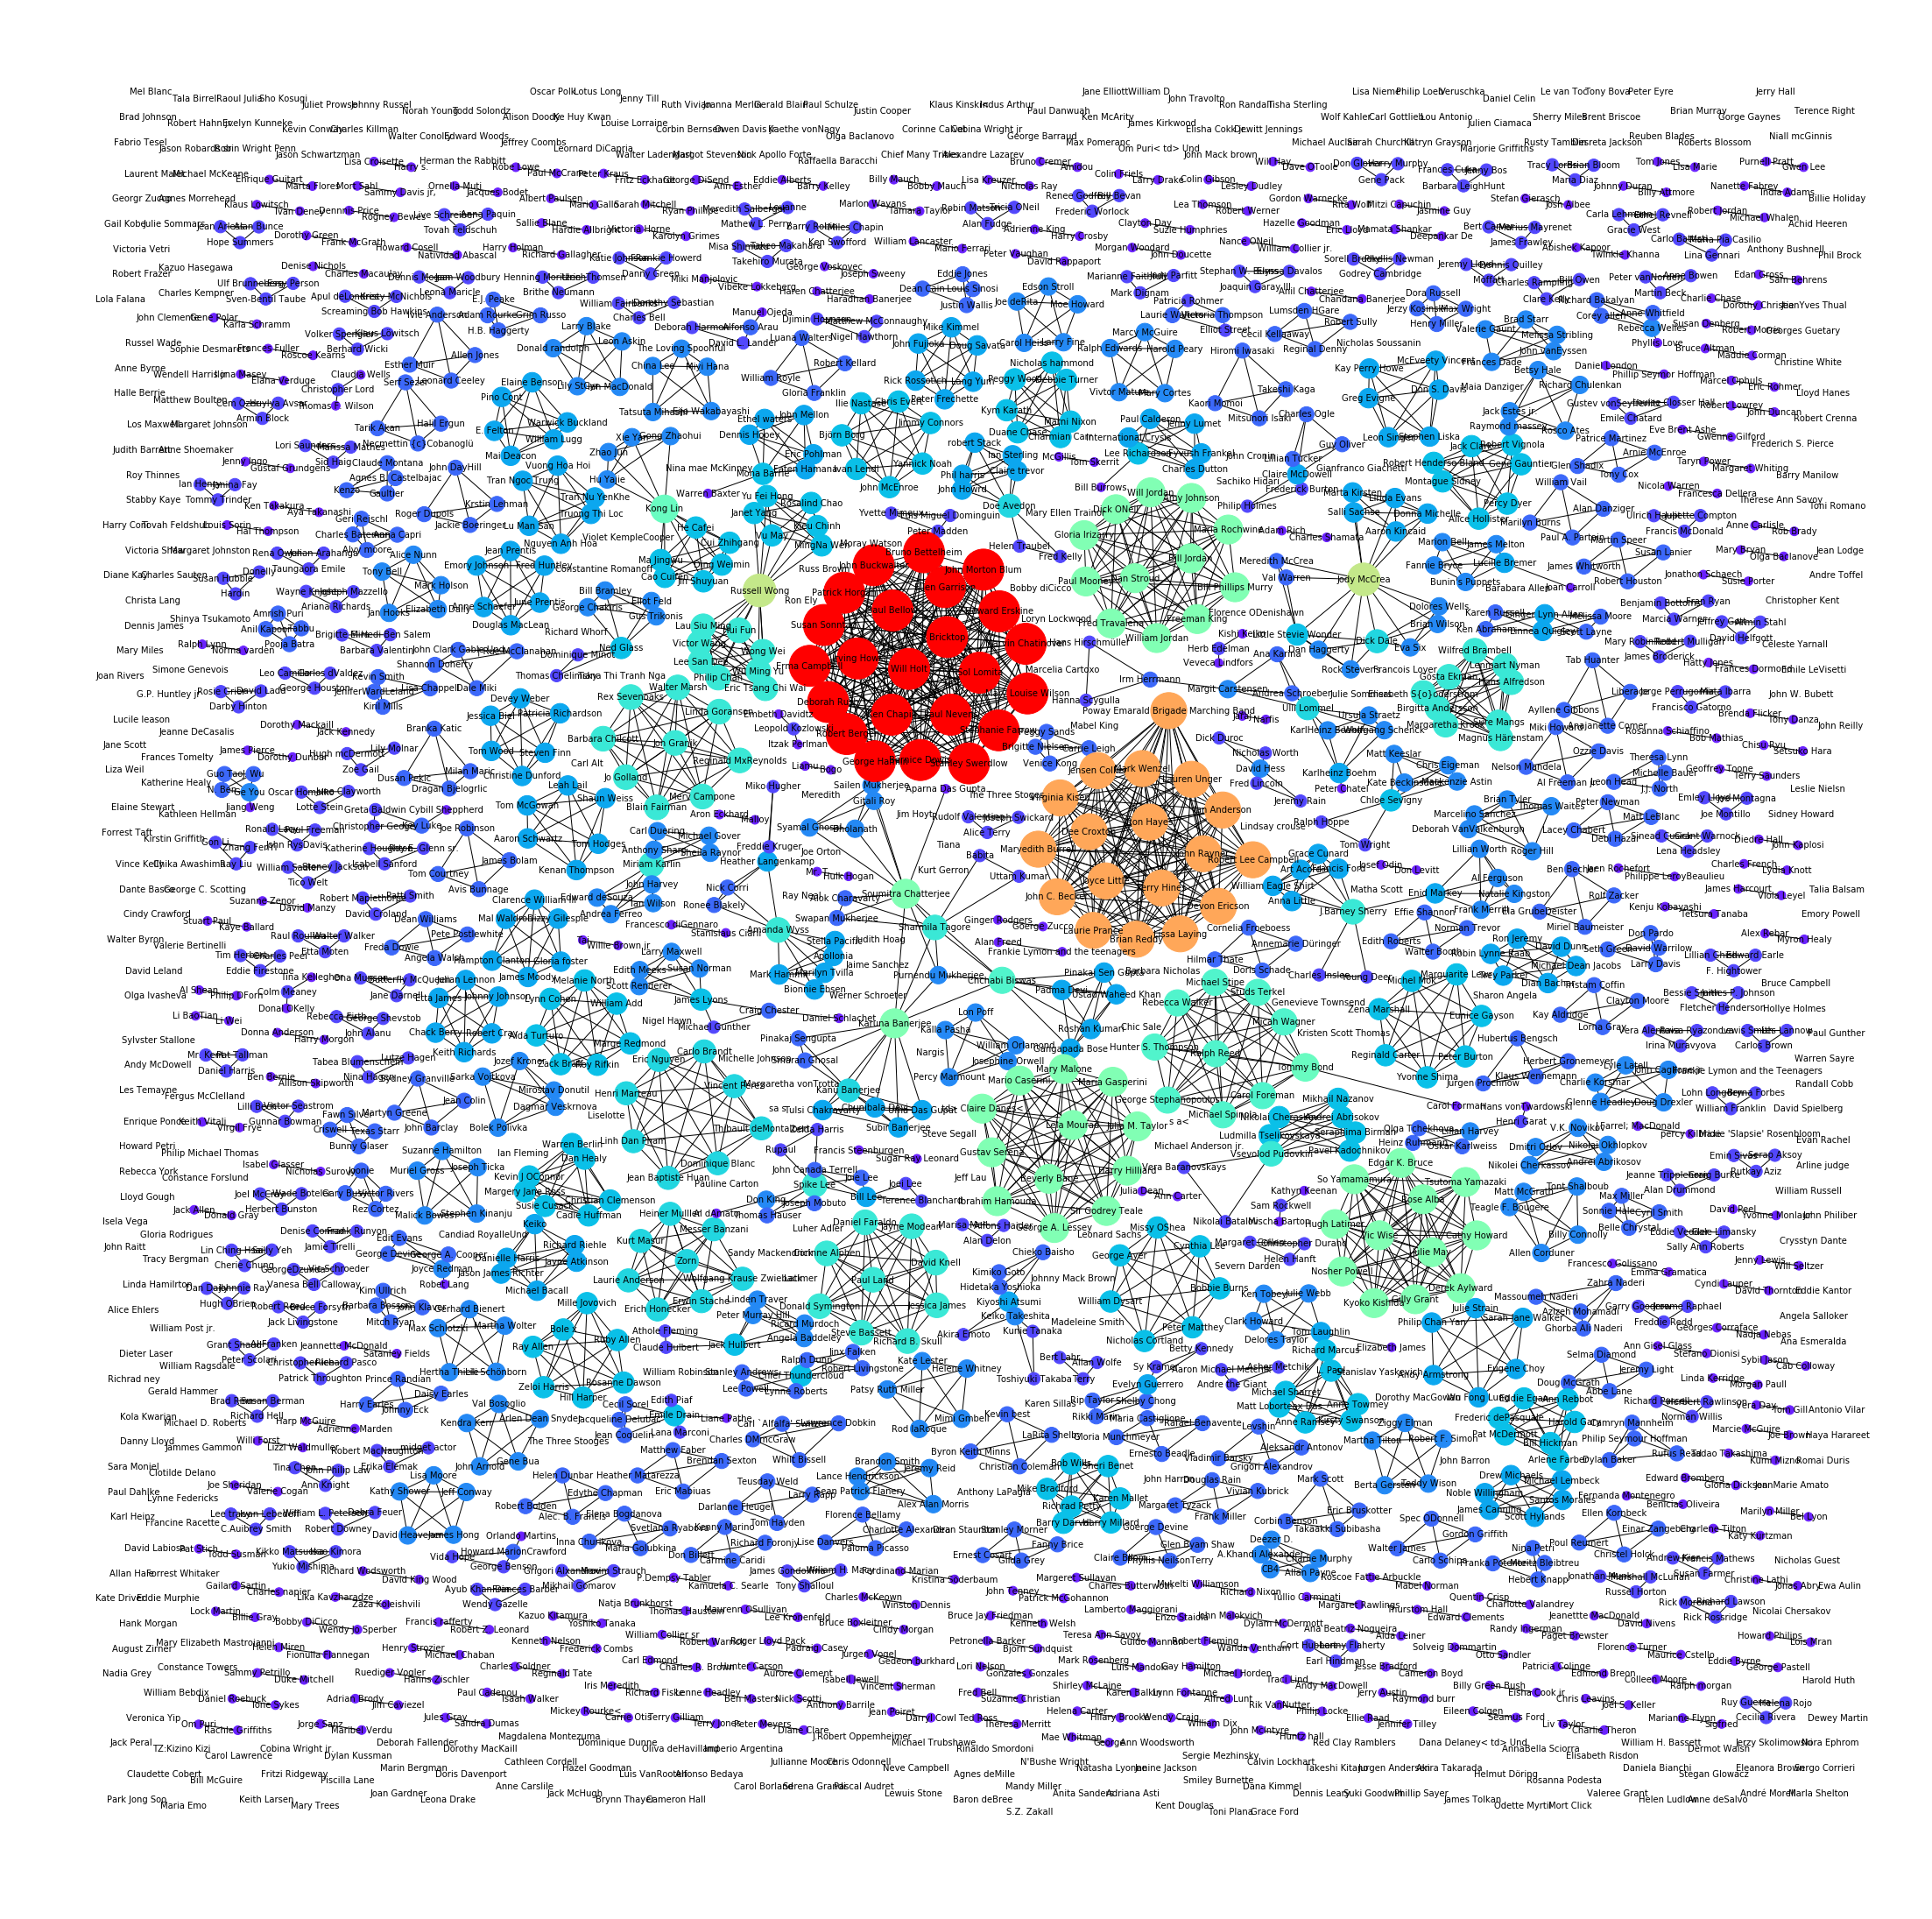

In [16]:
gx = copy.deepcopy(g)
for i in list(gx.nodes)[:-2000]:
    gx.remove_node(i)

plt.figure(figsize=(30,30))
pos = graphviz_layout(gx, prog="fdp")
nx.draw(gx, pos,
        labels={v:str(v) for v in gx},
        cmap = plt.get_cmap("rainbow"),
        node_color=[gx.degree(v) for v in gx],
        node_size=[100*gx.degree(v) for v in gx],
        font_size=10
       )
plt.savefig('../results/random.png')
plt.show()

In [17]:
def create_graph_modified(data, number_of_actors = 3):
    """Create graph from load records from csv."""
    g = nx.Graph()
    actors_in_film = {}
    
    for i in data:
        #g.add_node(i[2])
        if i[1] not in actors_in_film:
            actors_in_film[i[1]] = [] 
        actors_in_film[i[1]].append(i[2])

    for film in actors_in_film:
        if len(actors_in_film[film]) != number_of_actors: continue
        for actor in actors_in_film[film]:
            g.add_node(actor)
            for other_actor in actors_in_film[film]:
                if actor != other_actor:
                    g.add_edge(actor, other_actor)
    return g

In [18]:
def create_graph_to_file(gx, figsize, file_to_save, lock):
    plt.figure(figsize=figsize)
    pos = graphviz_layout(gx, prog="fdp")
    nx.draw(gx, pos,
            labels={v:str(v) for v in gx},
            cmap = plt.get_cmap("rainbow"),
            node_color=[gx.degree(v) for v in gx],
            node_size=[100*gx.degree(v) for v in gx],
            font_size=10
           )
    # Some problem with print to file parralel to other files using plt
    lock.acquire()
    plt.savefig(file_to_save) 
    lock.release()
    plt.close()

In [19]:
from multiprocessing import Process, Queue, Manager
# Use 8 core to test render 
m = Manager()
l = m.Lock()
process = []
process.append(Process(target=create_graph_to_file, args=(create_graph_modified(data, 3), (30,60), 
                                                          '../results/w3.png', l)))
process.append(Process(target=create_graph_to_file, args=(create_graph_modified(data, 5), (30,60), 
                                                          '../results/w5.png', l)))
process.append(Process(target=create_graph_to_file, args=(create_graph_modified(data, 7), (30,60), 
                                                          '../results/w7.png', l)))
process.append(Process(target=create_graph_to_file, args=(create_graph_modified(data, 9), (30,60), 
                                                          '../results/w9.png', l)))
process.append(Process(target=create_graph_to_file, args=(create_graph_modified(data, 11), (30,60), 
                                                          '../results/w11.png', l)))
process.append(Process(target=create_graph_to_file, args=(create_graph_modified(data, 14), (30,60), 
                                                          '../results/w14.png', l)))
process.append(Process(target=create_graph_to_file, args=(create_graph_modified(data, 18), (30,60), 
                                                          '../results/w18.png', l)))
process.append(Process(target=create_graph_to_file, args=(create_graph_modified(data, 22), (30,60), 
                                                          '../results/w22.png', l)))
for p in process:
    p.start()
for p in process:
    p.join() 